In [9]:
%matplotlib inline

In [10]:
#导入包
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
#求梯度
def gradient_w(X,w,b,y,C):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    g = np.zeros(len(w))
    for l in range(len(X)):
        if(1-y[l]*(w.dot(X[l]) + b)<=0):
            continue
        g -= y[l]*X[l]
    return C*g/len(X) + w
def gradient_b(X,w,b,y,C):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    g = 0
    for l in range(len(X)):
        if(1-y[l]*(w.dot(X[l]) + b)<=0):
            continue
        g -= y[l]
    return C*g/len(X)
#损失函数
def loss_function(X,w,b,y,C):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    sum = 0
    for i in range(len(X)):
        if(1-y[i]*(w.dot(X[i])+b)>0):
            sum += 1-y[i]*(w.dot(X[i])+b)
    return C*sum/len(X) + 0.5*w.dot(w)
#选取部分数据
def select(X,y,num=100):
    selection_X = []
    selection_y = []
    selectIndex = np.random.randint(0,len(X),num)
    for i in selectIndex:
        selection_X.append(X[i])
        selection_y.append(y[i])
    return np.array(selection_X),np.array(selection_y)
#NAG优化器
def NAG(X,w,b,y,trend_w,trend_b,C):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    if(len(w)!=len(trend_w)):
        raise "w和trend_w的长度不同"
    a = 0.5
    beta = 0.01
    #更新参数
    trend_w = a*trend_w + gradient_w(X,w - a * beta * trend_w,b - a * beta * trend_b,y,C)
    trend_b = a*trend_b + gradient_b(X,w - a * beta * trend_w,b - a * beta * trend_b,y,C)
    w = w - beta * trend_w
    b = b - beta * trend_b
    return w,b,trend_w,trend_b
#RMS_prop优化器
def RMSprop(X,w,b,y,r_w,r_b,C):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    if(len(r_w)!=len(w)):
        raise "r_w和w的长度不同"
    e = 0.005
    p = 0.9
    g_w = gradient_w(X,w,b,y,C)
    g_b = gradient_b(X,w,b,y,C)
    r_w = p*r_w + (1-p)*g_w*g_w
    r_b = p*r_b + (1-p)*g_b*g_b
    en_w = e/(np.sqrt(r_w)+1e-8)
    en_b = e/(np.sqrt(r_b)+1e-8)
    #更新参数
    w -= en_w * g_w
    b -= en_b * g_b
    return w,b,r_w,r_b
#Adadelta优化器
def Adadelta(X,w,b,y,r_w,r_b,s_w,s_b,C):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    if(len(r_w)!=len(w)):
        raise "r_w和w的长度不同"
    if(len(s_w)!=len(w)):
        raise "s_w和w的长度不同"
    p = 0.9
    g_w = gradient_w(X,w,b,y,C)
    g_b = gradient_b(X,w,b,y,C)
    s_w = p*s_w + (1-p)*g_w*g_w
    s_b = p*s_b + (1-p)*g_b*g_b
    move_w = np.sqrt(r_w+1e-8)/np.sqrt(s_w+1e-8)*g_w
    move_b = np.sqrt(r_b+1e-8)/np.sqrt(s_b+1e-8)*g_b
    r_w = p*r_w + (1-p)*move_w*move_w
    r_b = p*r_b + (1-p)*move_b*move_b
    w -= move_w
    b -= move_b
    return w,b,r_w,r_b,s_w,s_b
#Adam 优化器
def Adam(X,w,b,y,v_w,v_b,s_w,s_b,t,C):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    if(len(v_w)!=len(w)):
        raise "v和w的长度不同"
    if(len(s_w)!=len(w)):
        raise "s和w的长度不同"
    b1 = 0.9
    b2 = 0.999
    n = 0.01
    g_w = gradient_w(X,w,b,y,C)
    g_b = gradient_b(X,w,b,y,C)
    v_w = b1*v_w +(1-b1)*g_w
    v_b = b1*v_b + (1-b1)*g_b
    s_w = b2*s_w + (1-b2)*g_w*g_w
    s_b = b2*s_b +(1-b2)*g_b*g_b
    v_w_ = v_w/(1-b1**t)
    v_b_ = v_b/(1-b1**t)
    s_w_ = s_w/(1-b2**t)
    s_b_ = s_b/(1-b2**t)
    w -= n/np.sqrt(s_w_ + 1e-8)*v_w_
    b -= n/np.sqrt(s_b_ + 1e-8)*v_b_
    return w,b,v_w,v_b,s_w,s_b
#计算准确率
def accuracy(X,w,b,y):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    predict = np.array([w.dot(X[i])+ b for i in range(len(y))])
    predict[predict >=0] = 1
    predict[predict < 0] = -1
    error = predict - y
    error[error != 0] =1
    error_count = error.sum()
    return (len(y)-error_count)/len(y)
    

NAG 准确率： 0.800503654567
RMSprop 准确率： 0.778821939684
Adadelta 准确率： 0.763773723973
Adam 准确率： 0.794545789571


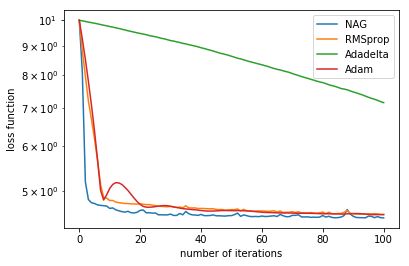

In [12]:
#读取训练数据
X_train,y_train = load_svmlight_file("a9a.txt")
X_train = X_train.toarray()
#读取验证数据
X_validation,y_validation = load_svmlight_file("a9a.t")
X_validation = X_validation.toarray()
#补全特征特征
zeros = [[0]]*len(X_validation)
X_validation = np.concatenate((X_validation,zeros),axis = 1)
#参数初始化
w_nag = np.zeros(len(X_train[0]))
b_nag = 0
trend_w = np.zeros(len(w_nag))
trend_b = 0
w_rms = np.zeros(len(X_train[0]))
b_rms = 0
r_w_rms = np.zeros(len(w_rms))
r_b_rms = 0
w_adadelta = np.zeros(len(X_train[0]))
b_adadelta = 0
r_w_adadelta = np.zeros(len(w_adadelta))
r_b_adadelta = 0
s_w_adadelta = np.zeros(len(w_adadelta))
s_b_adadelta = 0
w_adam = np.zeros(len(X_train[0]))
b_adam = 0
v_w = np.zeros(len(w_adam))
v_b = 0
s_w = np.zeros(len(w_adam))
s_b = 0
C =10
#保存各个优化方法的损失函数值
NAG_loss = [loss_function(X_validation,w_nag,b_nag,y_validation,C)]
RMSprop_loss = [loss_function(X_validation,w_rms,b_rms,y_validation,C)]
Adadelta_loss = [loss_function(X_validation,w_adadelta,b_adadelta,y_validation,C)]
Adam_loss = [loss_function(X_validation,w_adam,b_adam,y_validation,C)]
num_iteration = 100
for i in range(num_iteration):
    selected_X,selected_y = select(X_train,y_train)
    #进行NAG优化
    w_nag,b_nag,trend_w,trend_b = NAG(selected_X,w_nag,b_nag,selected_y,trend_w,trend_b,C)
    NAG_loss.append(loss_function(X_validation,w_nag,b_nag,y_validation,C))
    #进行RMSprot优化
    w_rms,b_rms,r_w_rms,r_b_rms = RMSprop(selected_X,w_rms,b_rms,selected_y,r_w_rms,r_b_rms,C)
    RMSprop_loss.append(loss_function(X_validation,w_rms,b_rms,y_validation,C))
    #进行Adadelta优化
    w_adadelta,b_adadelta,r_w_adadelta,r_b_adadelta,s_w_adadelta,s_b_adadelta = \
        Adadelta(selected_X,w_adadelta,b_adadelta,selected_y,r_w_adadelta,r_b_adadelta,s_w_adadelta,s_b_adadelta,C)
    Adadelta_loss.append(loss_function(X_validation,w_adadelta,b_adadelta,y_validation,C))
    #进行Adam优化
    w_adam,b_adam,v_w,v_b,s_w,s_b = Adam(selected_X,w_adam,b_adam,selected_y,v_w,v_b,s_w,s_b,i+1,C)
    Adam_loss.append(loss_function(X_validation,w_adam,b_adam,y_validation,C))
#画图
plt.plot(range(num_iteration+1),NAG_loss ,label="NAG")
plt.plot(range(num_iteration+1),RMSprop_loss,label = "RMSprop")
plt.plot(range(num_iteration+1),Adadelta_loss,label = "Adadelta")
plt.plot(range(num_iteration+1),Adam_loss,label = "Adam")
plt.yscale('log')
plt.legend(loc = "best")
ax = plt.gca()
ax.set_xlabel("number of iterations")
ax.set_ylabel("loss function")

print("NAG 准确率：",accuracy(X_validation,w_nag,b_nag,y_validation))
print("RMSprop 准确率：",accuracy(X_validation,w_rms,b_rms,y_validation))
print("Adadelta 准确率：",accuracy(X_validation,w_adadelta,b_adadelta,y_validation))
print("Adam 准确率：",accuracy(X_validation,w_adam,b_adam,y_validation))